# 0. Load the packages and specify the paths

In [1]:
# basics
import os
import numpy as np
import pandas as pd
from collections import Counter

# for data standardization
from sklearn.preprocessing import StandardScaler

# for PCA decomposition
from sklearn.decomposition import PCA

# for clustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram

# for spatial analysis
import geopandas as gpd

# for visualization
import matplotlib as mpl
from matplotlib import pyplot as plt

d:\python37\lib\site-packages\geopandas\_compat.py:110: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
# Specify the path
project_path = r'D:\Projects\count_tweet\poi_clustering'
data_path = os.path.join(project_path, 'data')
figure_path = os.path.join(project_path, 'figures')

In [3]:
# Function to setup the axis
def setup_axis(ax: plt.axis) -> None:
    """
    Set up the axis of the map, including:
        - xtick and ytick sizes
        - xlabel and ylabel sizes
    :param ax: a subplot axis
    :return: None. The axis is reformatted
    """
    # set the size of xticks and yticks
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    # set the size of x label and y label
    ax.xaxis.label.set_size(25)
    ax.yaxis.label.set_size(25)
    
# Set the font type
font = {'family': 'serif'}
mpl.rc('font', **font)

# 1. Load the data

### Load the POI data

In [4]:
poi_data = pd.read_csv(os.path.join(data_path, 'RESULTS_POI.csv'), encoding='utf-8')
poi_shapefile = gpd.read_file(os.path.join(data_path, 'RESULTS_POI.shp'), encoding='utf-8')

In [5]:
poi_shapefile_4326 = poi_shapefile.to_crs(epsg=4326)

In [6]:
select_columns = ['TW_ACTIVIT', '3D', '2D', '2C', '2A', '2E', '2F', '3E', '4B',
       '2B', '3C', '3B', '4A', '1C', '4C', '3A', '1A', '1B', 'SENTIMENT', 'geometry']

In [7]:
rename_dict = {'1A': 'LandDiverse', '1B': 'ResiVSNonResi', '1C': "HType", '2A': 'ComDen', '2B': 'NigDen', 
               '2C': 'DailyP', '2D': 'thirdP', '2E': 'DenDaily', '2F': 'DenNoDaily', '3A': 'BuildAge', 
               '3B': 'CovHisArea', '3C': 'SocialEven', '3D': 'PopDen', '3E': 'EmDen', '3F': 'EmPerCom', 
              '3G': 'RatioPopEmDen', '4A': 'BlockArea', '4B': 'IntersectDen', '4C': 'AnisoTro'}

### Rename the columns of POI data

In [8]:
select_columns_update = [rename_dict.get(colname, colname) for colname in select_columns]

In [9]:
poi_select = poi_shapefile_4326[select_columns].copy().rename(columns=rename_dict)

In [10]:
poi_select['id'] = list(range(poi_select.shape[0]))

In [11]:
poi_select.head()

,TW_ACTIVIT,PopDen,thirdP,DailyP,ComDen,DenDaily,DenNoDaily,EmDen,IntersectDen,NigDen,...,CovHisArea,BlockArea,HType,AnisoTro,BuildAge,LandDiverse,ResiVSNonResi,SENTIMENT,geometry,id
0,217.0,2.438,102,80,0.06256,0.15166,0.85687,5.11279,0.4777,0.0398,...,0.2617,2.4211,4.3507,0.460,29.88499,0.584515,0.45388,1.562212,"POLYGON ((18.63891 54.36464, 18.63916 54.36499...",0
1,40.0,11.490,665,732,0.91132,1.67609,5.50912,22.18760,1.2365,0.0092,...,0.0562,0.6120,4.1807,0.443,58.66411,0.429222,0.55778,1.650000,"POLYGON ((18.59857 54.37958, 18.59985 54.37958...",1
2,31.0,3.591,217,193,0.16793,0.34479,1.28271,8.57878,1.2577,0.0143,...,0.4016,0.8700,3.4506,0.461,83.38249,0.639931,0.59269,1.580645,"POLYGON ((18.60749 54.37065, 18.60792 54.37082...",2
3,1771.0,8.145,1320,1186,1.14932,1.90910,2.65439,20.14532,1.2781,0.2205,...,1.1107,0.2806,4.2920,0.419,200.61235,0.443443,0.88744,1.427442,"POLYGON ((18.64303 54.35228, 18.64311 54.35280...",3
4,1.0,2.357,61,53,0.15681,0.27704,0.59066,11.03446,1.1604,0.0052,...,0.0000,4.0083,4.1248,0.416,2.95813,0.595146,0.65275,1.000000,"POLYGON ((18.56475 54.39898, 18.56501 54.39932...",4


### Load the city border

In [12]:
tricity_border = gpd.read_file(os.path.join(data_path, 'tricity_border.shp'), encoding='utf-8')

### Double check the coordinate system

In [13]:
print("The coordinate system of the involved shapefiles: border: {}, poi: {}".format(
    tricity_border.crs.to_epsg(), poi_select.crs.to_epsg()))

The coordinate system of the involved shapefiles: border: 4326, poi: 4326


### Plot the boundary of city

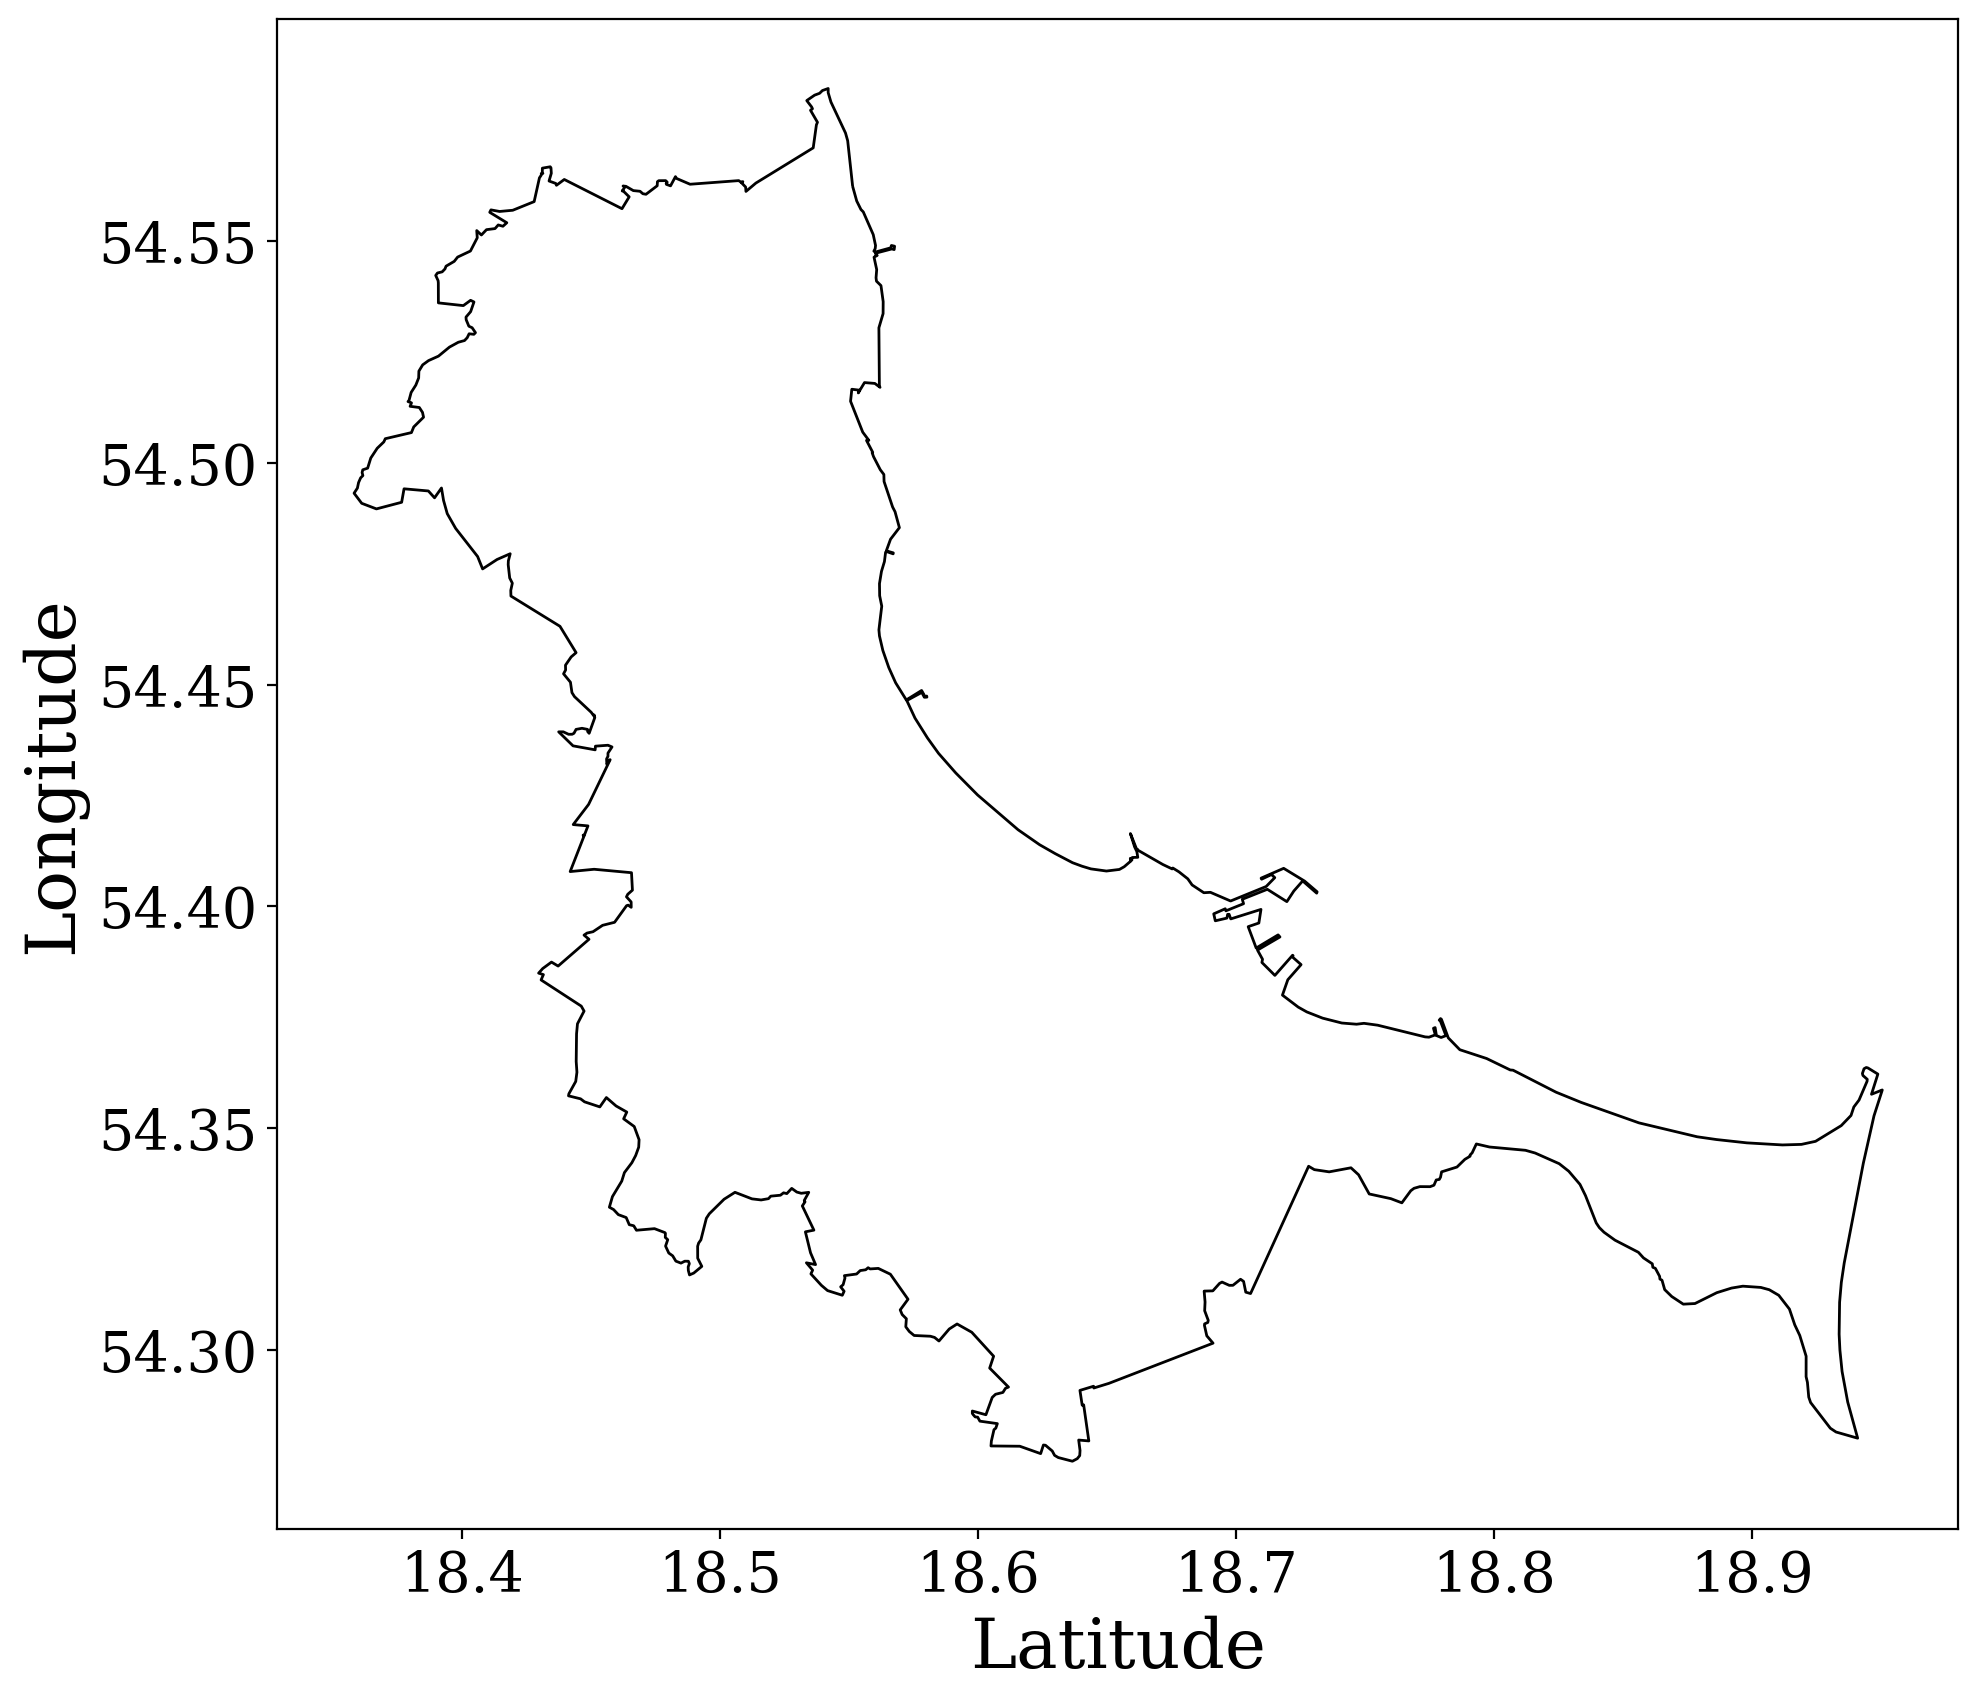

In [14]:
tricity_figure, tricity_axis = plt.subplots(1, 1, figsize=(17, 10), dpi=200)
tricity_border.plot(ax = tricity_axis, color='white', edgecolor='black', zorder=1)
tricity_axis.set_xlabel('Latitude', size=18)
tricity_axis.set_ylabel('Longitude', size=18)
tricity_axis.tick_params(axis="x", labelsize=12)
tricity_axis.tick_params(axis="y", labelsize=12)
setup_axis(tricity_axis)

# 2. Use PCA to select the number of factors

Reference papers: 

1. [The varimax criterion for analytic rotation in factor analysis](https://link.springer.com/article/10.1007/BF02289233)
2. [Big location-based social media messages from China's Sina Weibo network: Collection, storage, visualization, and potential ways of analysis](https://onlinelibrary.wiley.com/doi/abs/10.1111/tgis.12266)
3. [Understanding the impact of built environment on metro ridership using open source in Shanghai](https://www.sciencedirect.com/science/article/abs/pii/S0264275118307261)

In [15]:
select_columns_update.remove('geometry')

In [16]:
data_to_cluster = poi_select[select_columns_update].to_numpy()

In [17]:
data_to_cluster.shape

(817, 19)

### First, we need to standardize the data

In [18]:
scaler = StandardScaler()

In [19]:
scaler.fit(data_to_cluster)

StandardScaler()

In [20]:
standard_data = scaler.transform(data_to_cluster)

In [21]:
standard_data.shape

(817, 19)

### Next, use the PCA to do dimensionality reduction

In [22]:
# If n_components=None, n_components = min(n_samples, n_features)
pca = PCA(n_components=None, svd_solver='full')

In [23]:
pca_result = pca.fit(standard_data)

In [24]:
pca_result.explained_variance_ratio_

array([4.95521124e-01, 1.09449233e-01, 8.18041949e-02, 5.49918157e-02,
       4.82885892e-02, 4.19566399e-02, 3.94229962e-02, 3.17117294e-02,
       2.22978685e-02, 2.05345265e-02, 1.72302008e-02, 1.20092772e-02,
       8.91714435e-03, 5.66971040e-03, 4.61464655e-03, 3.55190187e-03,
       1.76841455e-03, 2.04511766e-04, 5.54753044e-05])

In [25]:
# Almost all the factor's singular values are greater than 1
pca_result.singular_values_

array([87.70390185, 41.21869051, 35.63490589, 29.21708329, 27.37852753,
       25.52044124, 24.73788937, 22.18695959, 18.60456431, 17.85377986,
       16.35433908, 13.65357132, 11.76523828,  9.38141325,  8.46363742,
        7.42537357,  5.23937965,  1.78175087,  0.92797799])

In [26]:
pca_result.n_components_

19

In [27]:
def plot_variance_increment(explained_variance_ratio: np.ndarray) -> None:
    """
    Plot the incremental variance based on the PCA explained variance
    :param explained_variance_ratio: the PCA explained variance ratio
    :return: a figure showing the incremental variance of factors
    """
    # Compute the incremental explained variance
    increment_variances = [0]
    for index, variance in enumerate(explained_variance_ratio):
        if index - 1>=0:
            increment_variances.append(variance + increment_variances[index])
        else:
            increment_variances.append(variance)
    xticks = list(range(len(increment_variances)))
    yticks = np.arange(0, 1.2, 0.2)
    
    # Draw the line graph finding the best number of PCA components
    figure, axis = plt.subplots(1, 1, figsize=(10, 8), dpi=200)
    axis.plot(xticks, increment_variances)
    axis.axhline(0.8, color='black', linestyle='--')
    axis.axvline(5, color='red', linestyle='--')
    
    # Setup the axis
    axis.set_xticks(xticks)
    axis.set_yticks(yticks)
    axis.set_yticklabels([str(int(val * 100))+'%' for val in yticks])
    axis.tick_params(axis="x", labelsize=12)
    axis.tick_params(axis="y", labelsize=12)
    axis.set_xlabel('Considered Number of PCA Components', size=18)
    axis.set_ylabel('Explained Variance', size=18)
    setup_axis(axis)
    
    # Save the figure and draw the plot
    figure.savefig(os.path.join(figure_path, 'variance_increment.png'))
    plt.show()

We plot the explained variance against the number of considered PCA components.

We find that the first five principal components accounting for 80% of the data.

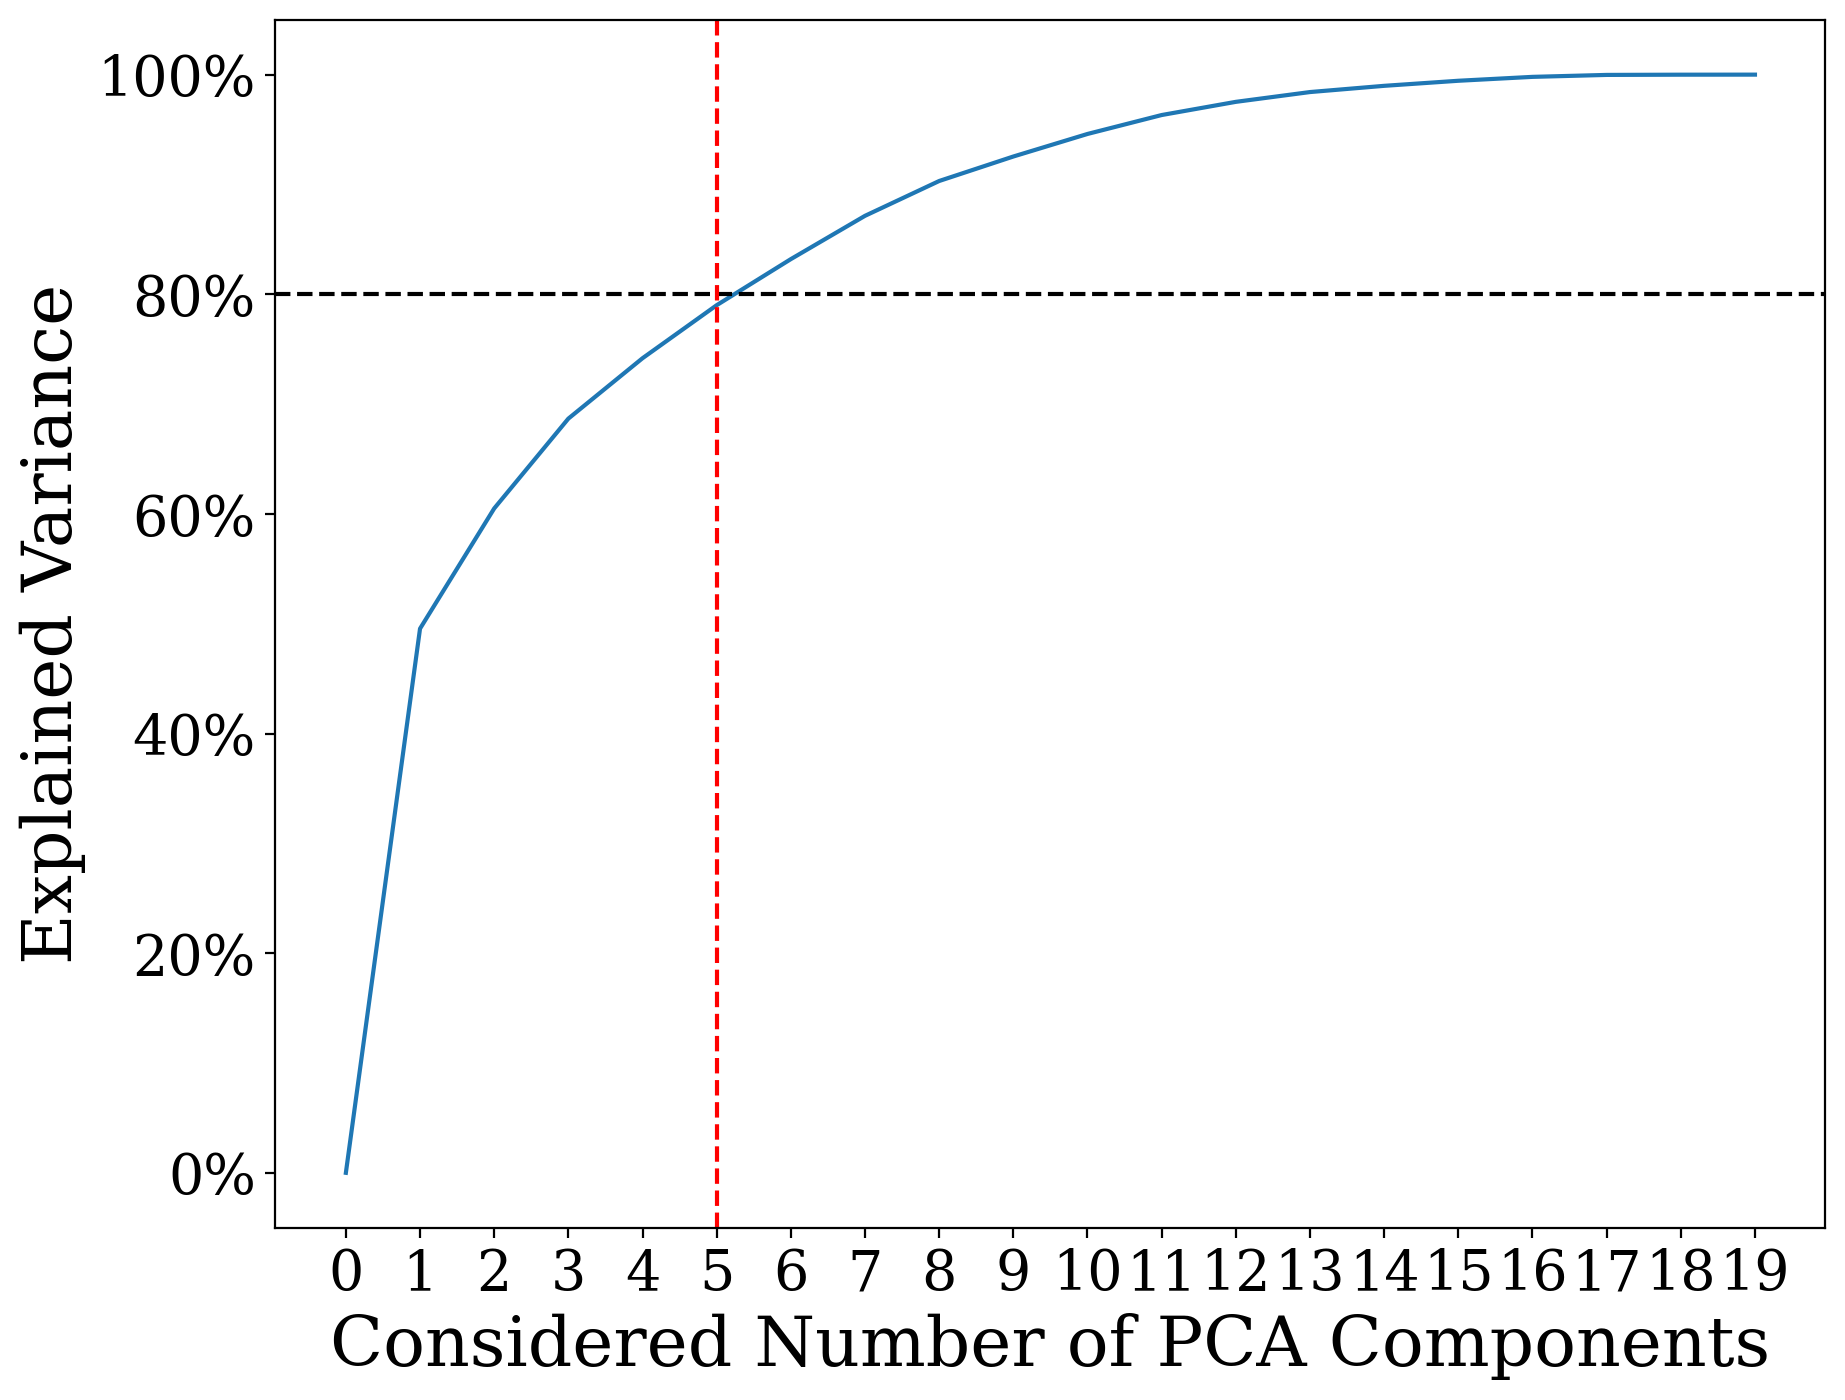

In [28]:
plot_variance_increment(pca_result.explained_variance_ratio_)

### Get the principal components and save the principal components to the pandas dataframe

In [29]:
principalComponents = PCA(n_components=5).fit_transform(standard_data)

In [30]:
principal_component_data = pd.DataFrame(principalComponents, 
                                        columns=['Principal_{}'.format(str(val)) for val in list(range(5))])

In [31]:
principal_component_data

,Principal_0,Principal_1,Principal_2,Principal_3,Principal_4
0,2.539868,-0.516004,-0.448187,0.696051,0.425522
1,-2.548978,-1.582173,1.528066,-0.196619,1.195178
2,1.328425,-0.943536,-0.517093,0.505295,0.903682
3,-5.070868,0.730653,-0.243565,0.012403,-0.393538
4,2.181181,-1.016311,0.255409,-0.393432,-0.471668
...,...,...,...,...,...
812,1.761130,0.449534,1.310789,0.311819,0.337001
813,4.339448,4.549297,7.012423,-0.792048,7.094162
814,3.664263,2.502304,4.825281,-1.288656,4.723926
815,-2.604876,-1.007139,1.738451,-0.258142,0.984741


### Compute the correlation between principal components and data

In [32]:
def compute_corr_dataframes(standard_data: np.ndarray, principal_data: np.ndarray, select_columns: list) -> pd.DataFrame:
    """
    Compute the correlation dataframe
    :param standard_data: the standardized data based on features
    :param principal_data: the principal components
    :param select_columns: the columns for correlation computation
    :return: a dataframe saving the correlation between data and principal component
    """
    components_num = principal_data.shape[1]
    principal_component_dataframe = pd.DataFrame(principal_data, 
                                        columns=['Principal_{}'.format(str(val)) for val in list(range(components_num))])
    standard_dataframe = pd.DataFrame(standard_data, columns=select_columns)
    
    correlations = []
    for principal_name in principal_component_dataframe.columns:
        principal_correlations = []
        for data_name in standard_dataframe.columns:
            correlation = np.corrcoef(principal_component_dataframe[principal_name], standard_dataframe[data_name])[0, 1]
            principal_correlations.append(correlation)
        correlations.append(principal_correlations)
    result_array = np.array(correlations).T
    result_dataframe = pd.DataFrame(result_array, 
                                    columns=['Principal_{}_corr'.format(str(val)) for val in list(range(components_num))], 
                                    index=select_columns)
    return result_dataframe

In [33]:
corr_dataframe = compute_corr_dataframes(standard_data, principalComponents, select_columns=select_columns_update)
corr_dataframe

,Principal_0_corr,Principal_1_corr,Principal_2_corr,Principal_3_corr,Principal_4_corr
TW_ACTIVIT,-0.883779,0.254235,-0.045203,-0.043025,-0.020208
PopDen,-0.642438,-0.485120,0.300211,0.107266,-0.088828
thirdP,-0.974933,0.130061,0.004568,-0.055603,0.034647
DailyP,-0.975883,0.088509,0.018967,-0.064500,0.045418
ComDen,-0.972886,0.089670,0.042815,-0.054159,0.039727
DenDaily,-0.982079,0.061258,0.040609,-0.058166,0.053537
DenNoDaily,-0.888476,-0.142916,0.079900,-0.050622,0.104412
EmDen,-0.841581,-0.012763,-0.111660,-0.093555,0.082511
IntersectDen,-0.749490,-0.232482,0.288535,0.112990,0.046070
NigDen,-0.854217,0.252210,-0.046899,0.139594,-0.103049


### Interpret these principal components

1. For reference: https://online.stat.psu.edu/stat505/lesson/11/11.4#:~:text=We%20use%20the%20correlations%20between,square%20root%20of%20the%20eigenvalue.
2. Pay attention to the correlation values of which **the absolute values are bigger or equal to 0.5**

The meaning of each component can be discussed as follows:

- Principal Component 1: The first variable increases with decreasing level of population density and place density. This component might refer to POIs in the suburban regions.
- Principal Component 2: The second variable increases with decreasing level of housing types, land diversity, and sentiment. Since there is a relatively strong positive relationship between this component and the coverage of historical places, this principal component might represent the historical sites with poor comments.
- Principal Component 3: The third variable increases with decreasing level of historical region, land diversity, and the increasing level of gap between residential area and non-residential area. This principal component might represent the POIs with low land use diversity.
- Principal Component 4: The fourth principal component increases with increasing number of social events and level of anisotropocity. This principal component represent the POIs with higher number of social events compared to other places.
- Principal Component 5: The fifth principal component increases with increasing sentiment level and block area. This indicates that places with larger block area tend to have higher level of sentiment. This principal component represent the POIs with large block area and higher level of sentiment (e.g., stadium and park).

### Save the correlations between the data and the principal components

In [34]:
# Save the correlation to the local directory
corr_dataframe.to_excel(os.path.join(data_path, 'corr_data.xlsx'))

### Get the transformed data for clustering

In [35]:
transformed_data = PCA(n_components=5).fit_transform(standard_data)

In [36]:
transformed_data.shape

(817, 5)

In [37]:
transformed_data

array([[ 2.5398682 , -0.51600253, -0.44818611,  0.69605739,  0.42549874],
       [-2.54897809, -1.58216911,  1.52807136, -0.19659496,  1.1951067 ],
       [ 1.32842537, -0.9435362 , -0.51709465,  0.50529343,  0.90367888],
       ...,
       [ 3.66426316,  2.50230321,  4.82527889, -1.28866495,  4.72394919],
       [-2.60487642, -1.00713806,  1.73845233, -0.25813768,  0.98473111],
       [ 3.30237359, -0.22487233, -0.40129123,  0.25151182,  1.3100835 ]])

# 3. Clustering analysis

### Hierarchical clustering

In [38]:
def draw_dendrogram(data: np.ndarray, color_threshold_val: float) -> None:
    # Plot the dendrogram
    figure, axis = plt.subplots(1, 1, figsize=(17, 10), dpi=200)
    axis.set_title('POI Clustering', size=20)
    axis.set_xlabel('POI places', size=18)
    axis.set_ylabel('Euclidean distances', size=18)
    dendrogram = sch.dendrogram(sch.linkage(data, method = 'ward', metric='euclidean'), 
                                color_threshold=color_threshold_val, 
                                above_threshold_color='black')
    axis.axhline(color_threshold_val, linestyle='--', color='black', alpha=0.8)
    
    # Edit the xlabels
    axis.set_xticks([])
    setup_axis(axis)
    
    # Save the figure
    figure.savefig(os.path.join(figure_path, 'dendrogram.png'), bbox_inches='tight')

We think setting the number of clusters equals 4 is appropriate, by checking the Euclidean distance between the pairs of data. Setting the number of clusters equals 5 is not appropriate, since there are only five instances in one cluster.

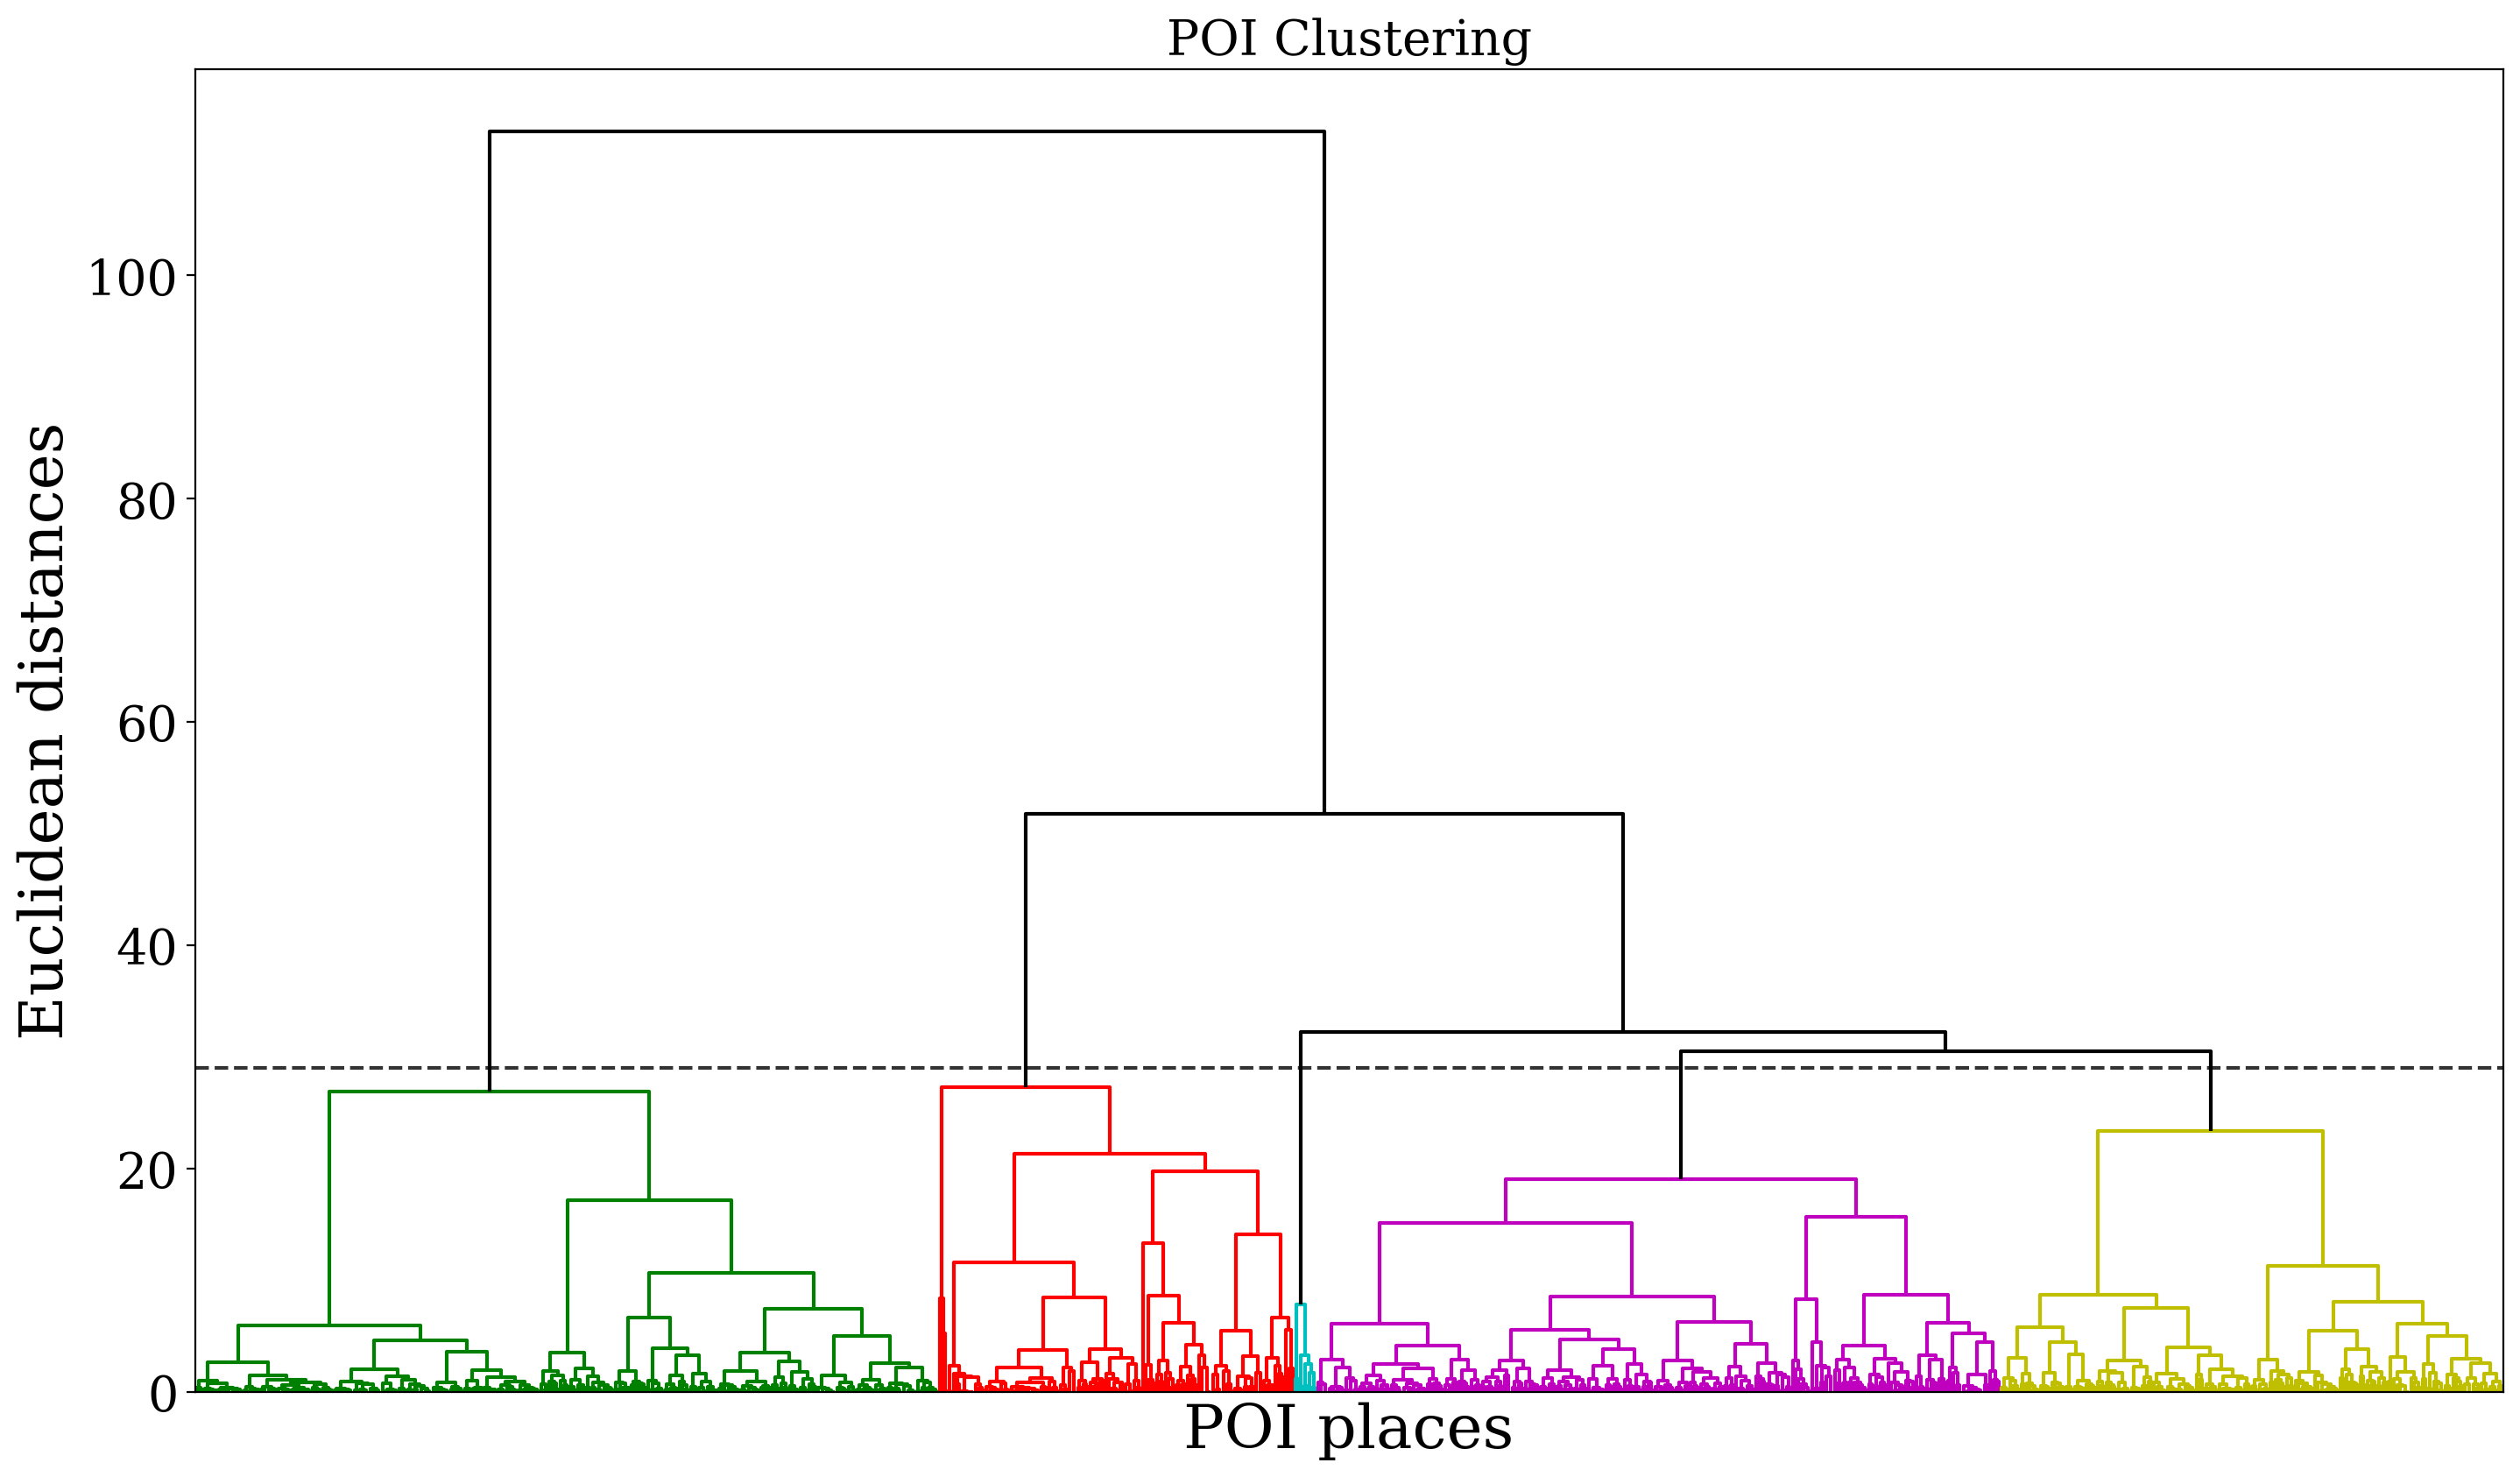

In [39]:
draw_dendrogram(data=transformed_data, color_threshold_val=29)

### Predict the labels

In [40]:
cluster_4 = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
cluster_4_labels = cluster_4.fit_predict(transformed_data)

In [41]:
Counter(cluster_4_labels)

Counter({0: 420, 1: 263, 2: 126, 3: 8})

In [42]:
cluster_5 = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
cluster_5_labels = cluster_5.fit_predict(transformed_data)

In [43]:
Counter(cluster_5_labels)

Counter({4: 242, 1: 263, 2: 178, 0: 126, 3: 8})

### Plot the pois belonging to different clusters

In [44]:
# Set the color code for plotting
color_dict = {0: '#DF7A5E', 1: '#3C405B', 2: '#82B29A', 3: '#F2CC8E', 4: '#FFF1DE'}

In [45]:
# Assign the labels to shapefile
poi_shapefile_4326['cluster_5'] = cluster_5_labels
poi_shapefile_4326['colors_5'] = poi_shapefile_4326.apply(lambda row: color_dict[row.cluster_5], axis=1)

poi_shapefile_4326['cluster_4'] = cluster_4_labels
poi_shapefile_4326['colors_4'] = poi_shapefile_4326.apply(lambda row: color_dict[row.cluster_4], axis=1)

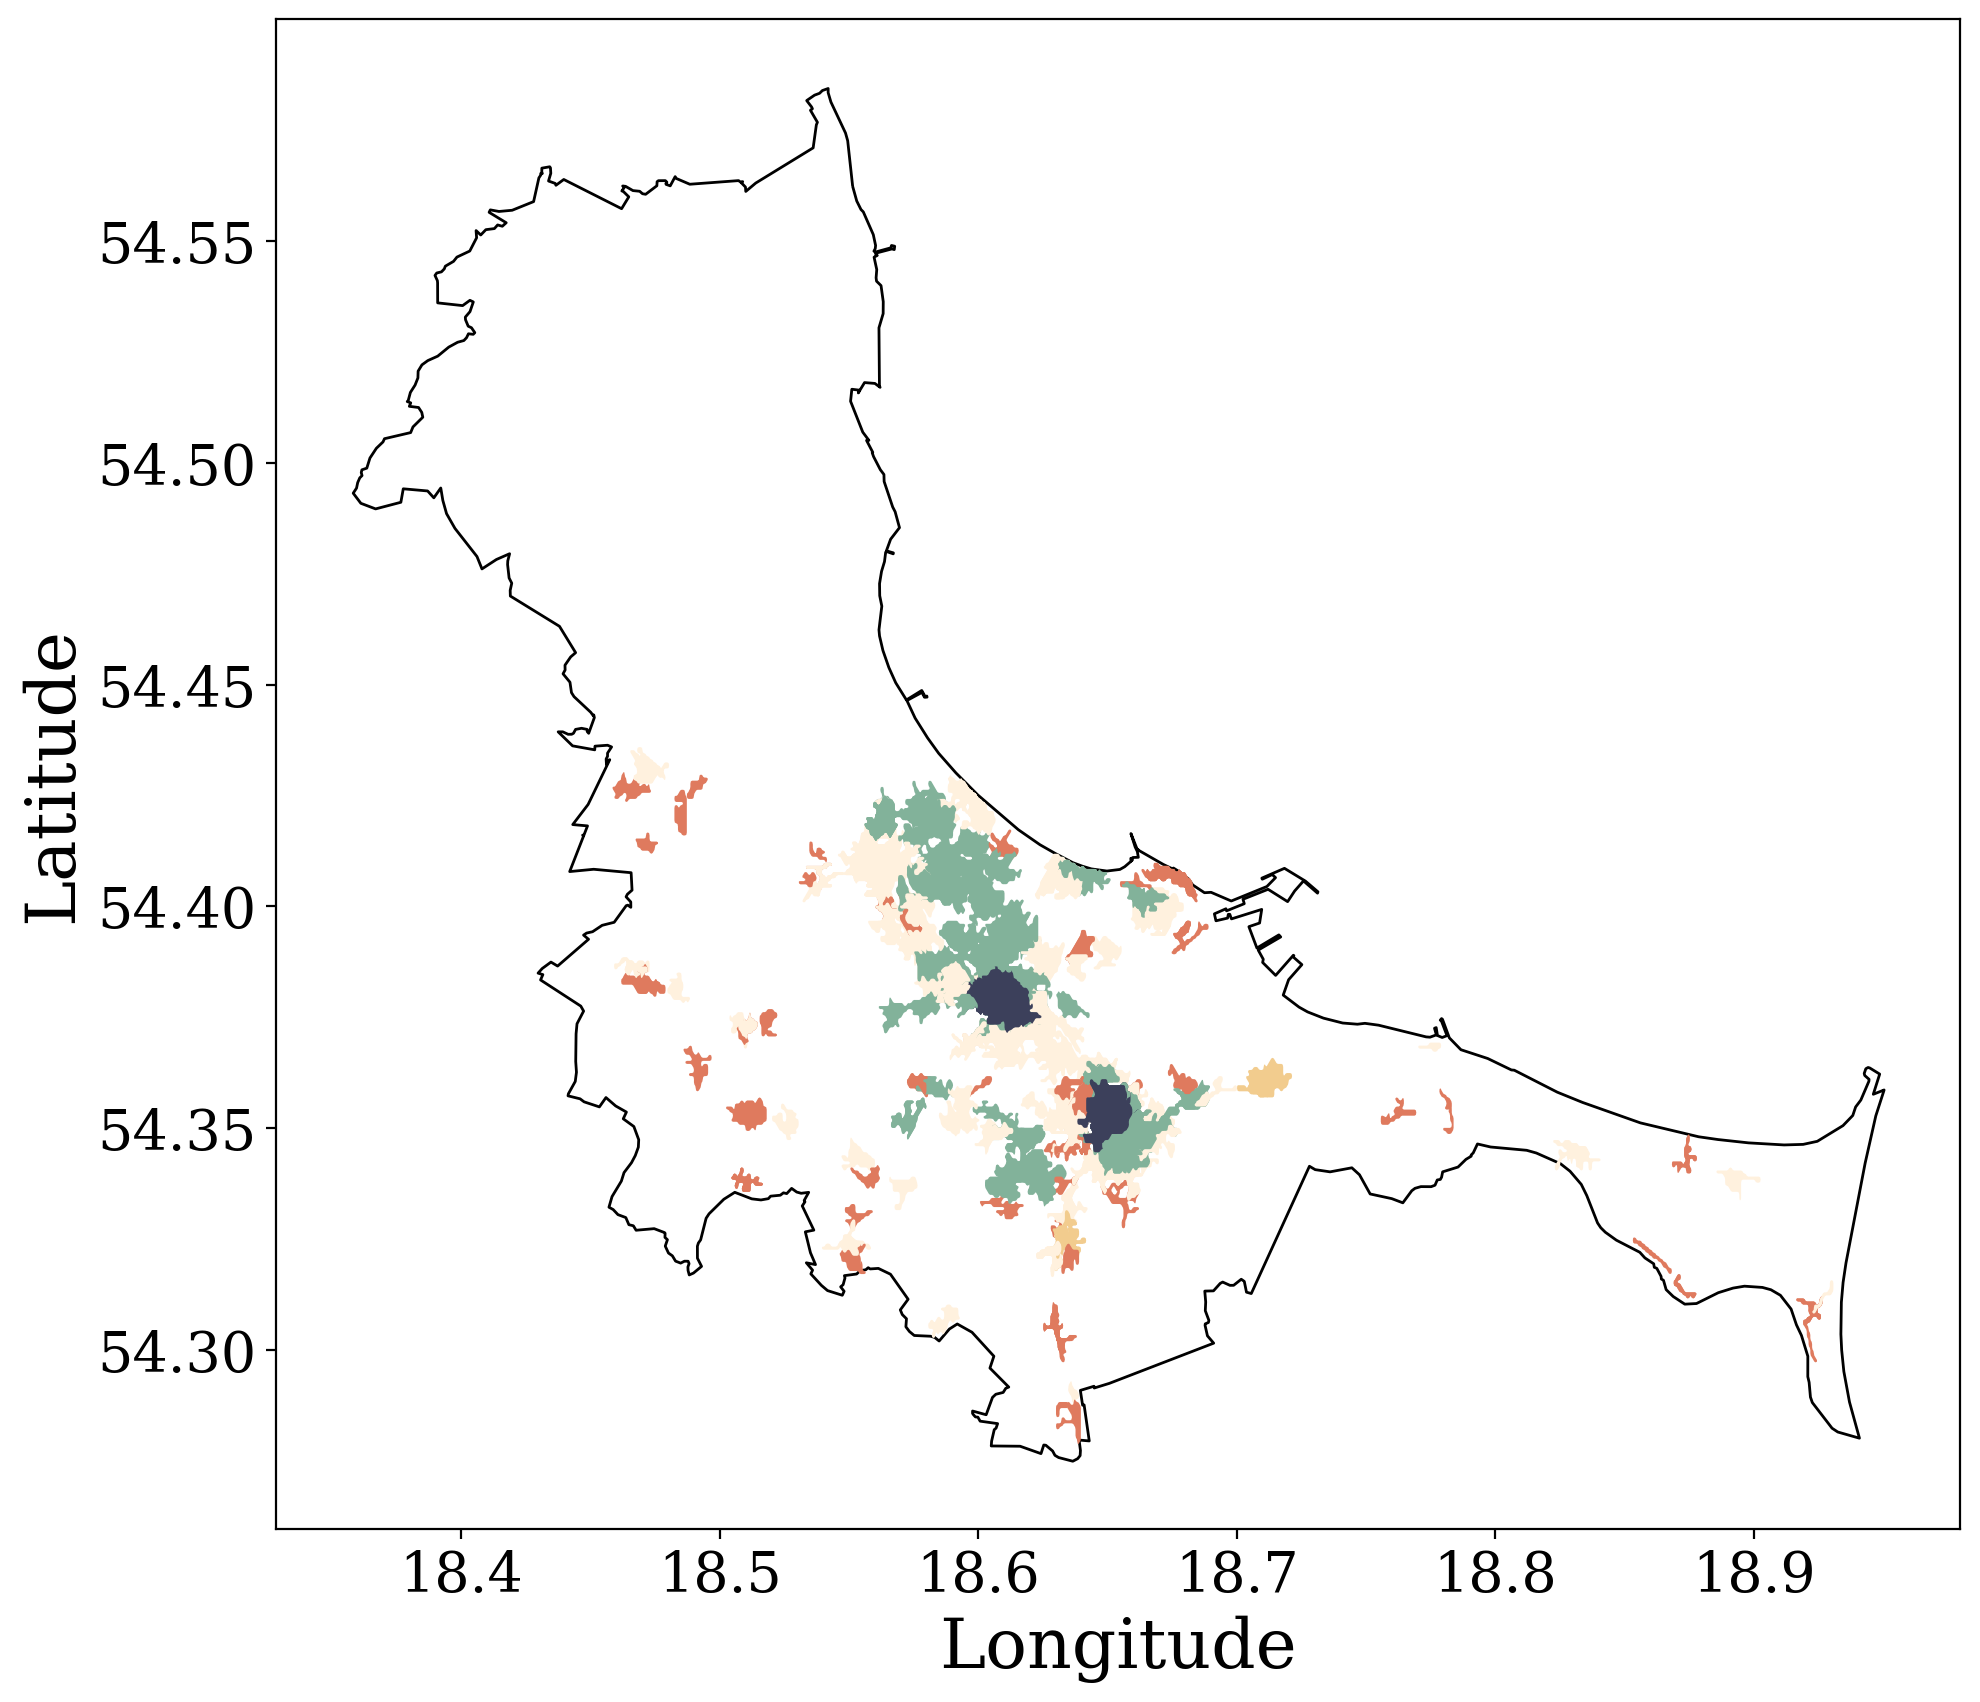

In [46]:
# Plot the POIs with 5 clusters
poi_figure_5, poi_axis_5 = plt.subplots(1, 1, figsize=(17, 10), dpi=200)
tricity_border.plot(ax=poi_axis_5, color='white', edgecolor='black', linewidth=1.0, zorder=1)
poi_shapefile_4326.plot(ax=poi_axis_5, legend=True, color=poi_shapefile_4326['colors_5'],
                        categorical=True, legend_kwds={'loc': "upper left"}, zorder=2)
poi_axis_5.set_xlabel('Longitude')
poi_axis_5.set_ylabel('Latitude')
setup_axis(poi_axis_5)
poi_figure_5.savefig(os.path.join(figure_path, 'poi_cluster_5.png'), bbox_inches='tight')

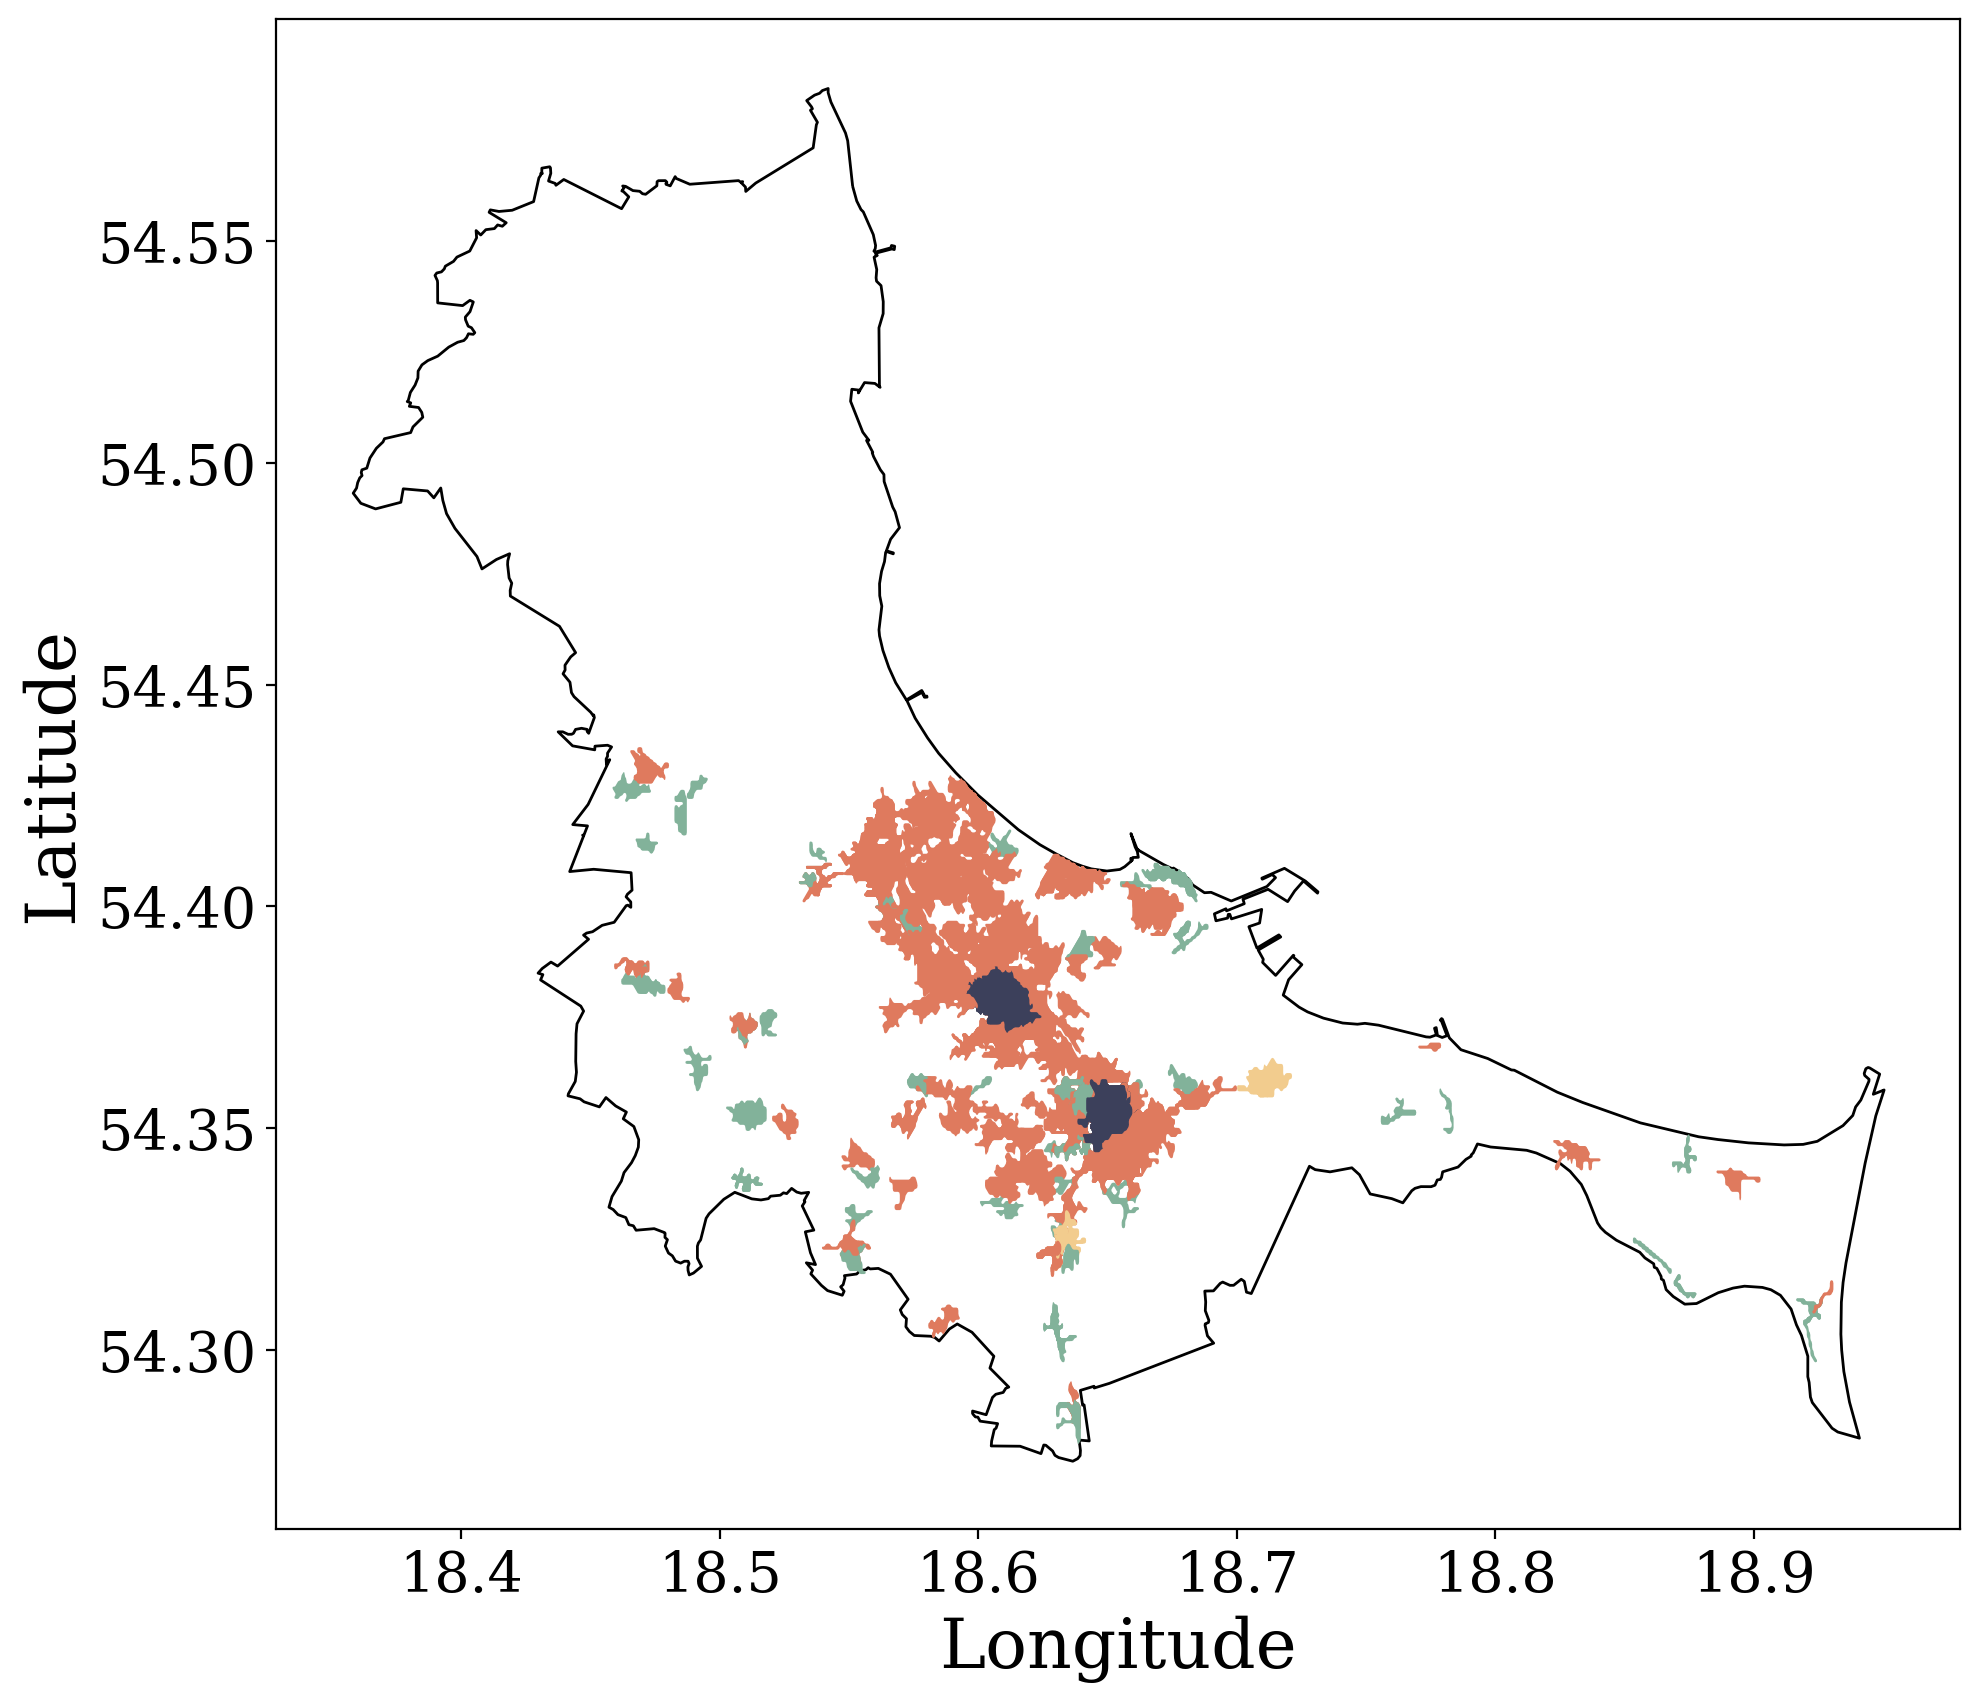

In [47]:
# Plot the POIs with 4 clusters
poi_figure_4, poi_axis_4 = plt.subplots(1, 1, figsize=(17, 10), dpi=200)
tricity_border.plot(ax=poi_axis_4, color='white', edgecolor='black', linewidth=1.0, zorder=1)
poi_shapefile_4326.plot(ax=poi_axis_4, legend=True, color=poi_shapefile_4326['colors_4'],
                        categorical=True, legend_kwds={'loc': "upper left"}, zorder=2)
poi_axis_4.set_xlabel('Longitude')
poi_axis_4.set_ylabel('Latitude')
setup_axis(poi_axis_4)
poi_figure_4.savefig(os.path.join(figure_path, 'poi_cluster_4.png'), bbox_inches='tight')

### Output the principal component values for each POI

Here we set the number of clusters equals 5

In [48]:
poi_select['clus_label'] = cluster_5_labels

In [49]:
principal_component_data = pd.DataFrame(transformed_data, columns=["PC_{}".format(val) for val in range(transformed_data.shape[1])])

In [50]:
concat_poi_data = pd.concat([poi_select, principal_component_data], axis=1)

In [51]:
np.arange(1, 11, 1).reshape(2,5).reshape(-1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

### Draw the box plot showing the values of principal components for each cluster

In [52]:
def process_boxplot_data(poi_with_pc_label, num_principals: int = 5):
    assert 'clus_label' in poi_with_pc_label, "The data should have a column named 'clus_label'"
    data_cluster_list = []
    cluster_labels = []
    for cluster_label, dataframe in poi_with_pc_label.groupby('clus_label'):
        cluster_labels.append(cluster_label)
        principal_vals = dataframe[['PC_{}'.format(val) for val in range(num_principals)]].to_numpy()
        data_cluster_list.append(principal_vals)
    return data_cluster_list, cluster_labels

def plot_boxplot(box_plot_values, cluster_labels):
    
    for values, label in zip(box_plot_values, cluster_labels):
        
        box_figure, box_axis = plt.subplots(figsize=(10, 8), dpi=200)
        box_axis.boxplot(values)
        print('For {}, the number of POIs in this cluster: {}'.format(label, values.shape[0]))
        box_axis.set_xticks(list(range(1, 6, 1)))
        box_axis.set_xticklabels(['PC{}'.format(val) for val in range(1, len(cluster_labels) + 1, 1)])
        setup_axis(box_axis)
        box_figure.savefig(os.path.join(figure_path, 'cluster_{}.png'.format(label)), bbox_inches='tight')
        plt.close()

In [53]:
cluster_values, cluster_labels = process_boxplot_data(concat_poi_data)

In [54]:
plot_boxplot(cluster_values, cluster_labels)

For 0, the number of POIs in this cluster: 126
For 1, the number of POIs in this cluster: 263
For 2, the number of POIs in this cluster: 178
For 3, the number of POIs in this cluster: 8
For 4, the number of POIs in this cluster: 242


### Save the clustering results for the following analysis

In [55]:
combined_data = pd.DataFrame(concat_poi_data)
combined_data.to_excel(os.path.join(data_path, 'poi_clustering_results.xlsx'))

In [56]:
concat_poi_data.to_file(os.path.join(data_path, 'poi_clustering_results.shp'), encoding='utf-8')

d:\python37\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """Entry point for launching an IPython kernel.
